# <center> Импорт библиотек <center>

In [1]:
import pickle
import random
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import augmentation as ag
import preprocessing as prep

# <center> Считывание и анализ данных <center>

В рамках этой задачи рассматривается датасет, где таргетами (целевыми значениями) являются штаммы бактерий *(strain)*, а в колонках признаков представлены векторы **m/z** *(масса на заряд)*; **time** *(время пролета)*; **Intens.** *(интенсивность)*; **SN**; **Res.** *(разрешение)*; **Area** *(площадь пика)*; **Rel. Intens.** *(Относительная интенсивность)*; **FWHM** *(полуширина)*; **Bk. Peak** *(базовый пик)*

In [2]:
with open('train.json', 'rb') as fp:
    train_d = json.load(fp)
train_df = pd.DataFrame(json.loads(train_d)).T
train_df.iloc[1].to_excel('tables.xlsx')
# train_df


- Так как масс-спектр - это зависимость относительной интенсивность пика *(Rel. Intens)* от отношения массы на заряд *(m/z)*, их оставляем для дальнейшей обработки и обучения.
- Уберем колонки **Res**, **SN** и **FHMW**, так как они являются характеристиками масс-спектрометра и не будут влиять на качество пресказания модели, а также колонку **Bk. Peak**, так как она нулевая.
- Рассмотрим матрицу корреляций оставшихся признаков, чтобы отбросить коррелирующие

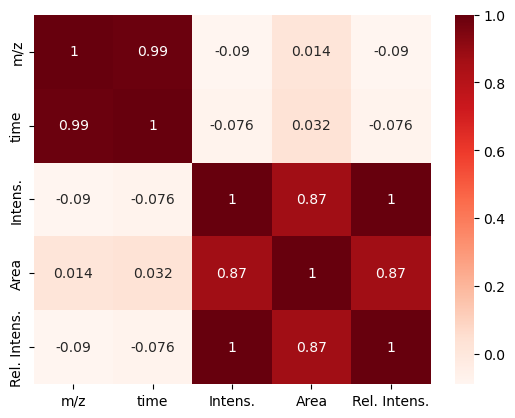

In [3]:
FEATURES = ['m/z', 'time', 'Intens.', 'Area', 'Rel. Intens.']
example = train_df[FEATURES]\
        .loc[(train_df.strain=='Acinetobacter baumani_126')].iloc[0]

example = pd.DataFrame(list(example)).T
example.columns = FEATURES

cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('Plots/corr_matr.png')
plt.show()

Исходя из данных матрицы корреляции все оставшиеся признаки коррелируют либо с *m/z*, либо с *Rel. Intens.*, так что можно убрать все кроме этих двух. 

In [4]:
new_train_df = train_df[['strain', 'm/z', 'Rel. Intens.']]
new_train_df

,strain,m/z,Rel. Intens.
0,Acinetobacter baumani_121 skin,"[2131.496344969094, 2259.721110106408, 2588.85...","[0.07505194053740191, 0.02299955353863887, 0.0..."
1,Acinetobacter baumani_126,"[2132.413484429545, 2589.569703463259, 2718.11...","[0.02893426423838925, 0.04349658472700257, 0.0..."
2,Acinetobacter baumani_352 blood,"[2132.015451945306, 2153.878241508351, 2259.87...","[0.08492296048402985, 0.02209876685915333, 0.0..."
3,Acinetobacter baumani_377 blood,"[2132.20685843954, 2260.448073902672, 2718.433...","[0.06574632118612184, 0.02558736537491051, 0.0..."
4,Acinetobacter baumani_503 blood,"[2133.566060793301, 2590.134696892168, 2808.64...","[0.0366567284548468, 0.07359986741847667, 0.05..."
...,...,...,...
251,Pseudomonas fluorescence_965,"[2043.498150902115, 2121.3512161395, 2173.4033...","[0.03832348130527499, 0.03930522900307439, 0.0..."
252,Staphilococcus aureus_11 K817,"[2045.425912886147, 2141.662374781331, 2153.66...","[0.03512664062620777, 0.04690858875525017, 0.0..."
253,Staphilococcus aureus_12 K457,"[2045.196519439769, 2049.120332799548, 2069.74...","[0.07274829357476373, 0.0667451186195874, 0.06..."
254,Staphilococcus aureus_15,"[2141.771015437851, 2154.309712813744, 2181.35...","[0.1333500740518391, 0.09396161635612435, 0.07..."


# <center> Подготовка данных к тренировке модели <center>


In [5]:
new_train_df = ag.generate_new(new_train_df)
new_train_df

/home/anubis/Desktop/Bio-ML/sample_solution/augmentation.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'n_peak'] = train_df['m/z'].apply(len)


,strain,m/z,Rel. Intens.,n_peak
0,Acinetobacter baumani_121 skin,"[2131.496344969094, 2259.721110106408, 2588.85...","[0.07505194053740191, 0.02299955353863887, 0.0...",65
1,Acinetobacter baumani_126,"[2132.413484429545, 2589.569703463259, 2718.11...","[0.02893426423838925, 0.04349658472700257, 0.0...",86
2,Acinetobacter baumani_352 blood,"[2132.015451945306, 2153.878241508351, 2259.87...","[0.08492296048402985, 0.02209876685915333, 0.0...",84
3,Acinetobacter baumani_377 blood,"[2132.20685843954, 2260.448073902672, 2718.433...","[0.06574632118612184, 0.02558736537491051, 0.0...",64
4,Acinetobacter baumani_503 blood,"[2133.566060793301, 2590.134696892168, 2808.64...","[0.0366567284548468, 0.07359986741847667, 0.05...",63
...,...,...,...,...
485,Staphilococcus aureus_K160,"[2045.410607630293, 2051.549365999239, 2070.32...","[0.0685688292295182, 0.06088170528704751, 0.06...",86
486,Staphilococcus aureus_K160,"[2043.562407192735, 2051.549365999239, 2069.82...","[0.06086922493181035, 0.06088170528704751, 0.0...",90
487,Staphilococcus aureus_K160,"[2045.317024367366, 2052.141462842376, 2070.41...","[0.08819864221226346, 0.05745820209032081, 0.0...",95
488,Staphilococcus aureus_K160,"[2045.820275547185, 2051.549365999239, 2070.41...","[0.06645393127673135, 0.06088170528704751, 0.0...",94


In [6]:
np.random.seed(142)
val_ds = pd.DataFrame()
train_ds = pd.DataFrame()
for strain in new_train_df.strain.unique():
    n = np.random.randint(4,6)
    ids = random.sample(list(new_train_df.loc[new_train_df.strain == strain].index), n)
    val_ds = pd.concat([val_ds, new_train_df.loc[ids]])
    train_ids = list(set(new_train_df.loc[new_train_df.strain == strain].index) - set(ids))
    train_ds = pd.concat([train_ds, new_train_df.loc[train_ids]])

In [7]:
val_ds = prep.prepocess_data(val_ds)
test_ds = prep.prepocess_data(train_ds)

In [8]:
val_ds = val_ds.sample(frac=1)
train_ds = train_ds.sample(frac=1)

# <center> Тренировка моделей <center>

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score , accuracy_score

## Логистическая регрессия (многоклассовый классификатор)

In [10]:
X = prep.make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [11]:
lr_clf = LogisticRegression(random_state = 0)
clf = make_pipeline(StandardScaler(), lr_clf)
clf.fit(X,y)

/home/anubis/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

In [12]:
X_pred = prep.make_x(val_ds, col='intens')
Y_pred = clf.predict(X_pred)

In [13]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.9665889665889666 0.9666666666666667


In [14]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables\lr_multi_clf.xlsx')

In [15]:
swmPickle = open('Models/LR_multi/lr_multi_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)   

## Логистическая регрессия (набор бинарных классификаторов)

In [16]:
X = prep.make_x(train_ds, col='intens')

Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

class_order = train_ds.strain.unique()

In [17]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = LogisticRegression(random_state = 0)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])
    strain = class_order[i]
    pickle.dump(clf, open(f'Models/LR_bin/lr_bin_clf_{strain}.pkl', 'wb'))

In [18]:
res = np.array(res).T

Y_pred = []
for res_i in res:
    Y_pred.append(class_order[np.where(res_i == max(res_i))[0]].item())

In [19]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.918034743034743 0.9166666666666666


In [55]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/lr_bin_clf.xlsx')

## SVM (многоклассовый классификатор)

In [21]:
X = prep.make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [22]:
svm_clf = SVC(gamma='auto', kernel='sigmoid', probability=True)
clf = make_pipeline(StandardScaler(), svm_clf)
clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='sigmoid', probability=True))])

In [23]:
X_pred = prep.make_x(val_ds, col='intens')
Y_pred = clf.predict(X_pred)

In [24]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.8412087912087913 0.85


In [25]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/svm_multi_clf.xlsx')

In [26]:
swmPickle = open('Models/SVM_multi/svm_multi_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)

## SVM (набор бинарных классификаторов)

In [27]:
X = prep.make_x(train_ds, col='intens')

Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

class_order = train_ds.strain.unique()

In [28]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = SVC(gamma='scale', kernel='sigmoid', probability=True)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])
    strain = class_order[i]
    pickle.dump(clf, open(f'Models/SVM_bin/svm_bin_clf_{strain}.pkl', 'wb'))

In [29]:
res = np.array(res).T

Y_pred = []
for res_i in res:
    Y_pred.append(class_order[np.where(res_i == max(res_i))[0]].item())

In [30]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.9593822843822845 0.9583333333333334


In [31]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/svm_bin_clf.xlsx')

## Дерево решений (многоклассовый классификатор)

In [60]:
X = prep.make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [64]:
tree_clf = DecisionTreeClassifier(random_state=0, criterion='gini')
clf = make_pipeline(StandardScaler(), tree_clf)
clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

In [65]:
X_pred = prep.make_x(val_ds, col='intens')
Y_pred = clf.predict(X_pred)

In [66]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.831965470427009 0.8333333333333334


In [36]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/tree_multi_clf.xlsx')

In [37]:
swmPickle = open('Models/TREES_multi/tree_multi_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)

## Дерево решений (набор бинарных классификаторов)

In [76]:
X = prep.make_x(train_ds, col='intens')

Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

class_order = train_ds.strain.unique()

In [77]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = DecisionTreeClassifier(random_state=0, criterion='gini')
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])
    strain = class_order[i]
    pickle.dump(clf, open(f'Models/TREES_bin/tree_bin_clf_{strain}.pkl', 'wb'))

In [78]:
res = np.array(res).T

Y_pred = []
for res_i in res:
    Y_pred.append(class_order[np.where(res_i == max(res_i))[0][0]])

In [79]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.5844544344544345 0.5916666666666667


In [42]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/trees_bin_clf.xlsx')

## Случайный лес (многоклассовый классификатор)

In [43]:
X = prep.make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [44]:
forest_clf = RandomForestClassifier(random_state=0)
clf = make_pipeline(StandardScaler(), forest_clf)
clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [45]:
X_pred = prep.make_x(val_ds, col='intens')
Y_pred = clf.predict(X_pred)

In [46]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.9914529914529915 0.9916666666666667


In [47]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/forest_multi_clf.xlsx')

In [53]:
swmPickle = open('Models/FOREST_multi/forest_multi_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)

# Случайный лес (набор бинарных классификаторов)

In [48]:
X = prep.make_x(train_ds, col='intens')

Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

class_order = train_ds.strain.unique()

In [49]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = RandomForestClassifier(random_state=0)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])
    strain = class_order[i]
    pickle.dump(clf, open(f'Models/FOREST_bin/forest_bin_clf_{strain}.pkl', 'wb'))

In [50]:
res = np.array(res).T

Y_pred = []
for res_i in res:
    Y_pred.append(class_order[np.where(res_i == max(res_i))[0][0]])

In [51]:
print(f1_score(Y_pred, val_ds.strain, average='macro'), accuracy_score(Y_pred, val_ds.strain))

0.973914973914974 0.975


In [52]:
metric_list = []
for pos_strain in val_ds.strain.unique():
    target_arr = [int(list(val_ds.strain)[i]==pos_strain) for i in range(len(val_ds.strain))]
    pred_arr = [int(Y_pred[i] == pos_strain) for i in range(len(val_ds.strain))]
    metric_list.append([pos_strain, accuracy_score(pred_arr, target_arr), f1_score(pred_arr, target_arr)])

metric_df = pd.DataFrame(metric_list)
metric_df.to_excel('Tables/forest_bin_clf.xlsx')